Topic Modeling Using Distributed Word Embeddings
================================================
Notebook version of https://github.com/rsrandhawa/Vec2Topic code, based on the article "Topic Modeling Using Distributed Word Embeddings" by R. S. Randhawa, P. Jain, and G. Madan. 

The basic approach is to first create a language model based on a large (ideally billions of words) text corpus. The technology used, distributed word embeddings, is a shallow neural network that seems to perform best on large datasets (trades simple but fast computation for tons of data).

The user generated content (which is usually a much smaller corpus) is likewise trained with consistent parameters. Vectors corresponding to the same vocabulary word are concatenated together to provide a model of the user generated content.

Word vectors that cluster together are interperted as topics of the user generated content. Some clusters appear better than others because they consist of coherent lists of words -- main goal is to score the importance of each topic.

Performing a hierarchical clustering provides a measure of depth for each word and computing a co-occurance graph (edge between two words if they belong to the same sentenence) provides a degree of co-occurance. Each word is scored by a (normalized) product of depth and degree. KMeans is used to cluster words into topics, and the scoring function is used to order the words and the topics.

Required standard packages
--------------------------

In [1]:
import logging, re, os, bz2
from collections import Counter
from operator import itemgetter
import itertools

In [2]:
## Unicode wrapper for reading & writing csv files.
import unicodecsv as csv

## Lighter weight than pandas -- tabular display of tables.
from tabulate import tabulate

## In order to strip out the text from the xml formated data.
from bs4 import BeautifulSoup
import lxml

Required data science packages
------------------------------

In [3]:
## First the usual suspects: numpy, scipy, and gensim
import numpy as np
import scipy as sp
import gensim

## For scraping text out of a wikipedia dump. Get dumps at https://dumps.wikimedia.org/backup-index.html
from gensim.corpora import WikiCorpus

## For computing phrases from input text.
from gensim.models.phrases import Phrases

from textblob import TextBlob
import nltk

## Compute 2D projection of combined word vectors and display them with pandas & bokeh.
import bhtsne

## Latest greatest word vectors (see https://pypi.python.org/pypi/fasttext).
import fasttext

## Latest greatest hierarchical clustering package. 
## Word vectors are clustered, with deeper trees indicating core topics.
import fastcluster

## Use scikit-learn to generate co-occurancy graph (edge if words in same sentence).
## The degree of each word indicates how strong it co-occurs.
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

## Use scikit-learn for K-Means clustering: identify topics.
from sklearn.cluster import KMeans

Base data directory and logging.
--------------------------------
The approach currently uses a lot of intermediate files (which is annoying, but means that the project can work on machines with smaller physical memory). The initial data (knowledge base as well as user generated content) and the intermediate files are all kept in the data directory.

In [4]:
data_directory = 'data/'
model_directory = 'models/'

In [5]:
from imp import reload
reload(logging)

LOG_FILENAME = data_directory + 'vec2topic.log'
#logging.basicConfig(filename=LOG_FILENAME,level=logging.INFO)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s %(message)s',"%b-%d-%Y %H:%M:%S")
logger.handlers[0].setFormatter(formatter)

List of intermediate files.
---------------------------
The (global) knowledge base is built off a (large) dataset.

In [6]:
## Main inputs to program. Data for model and name of knowledge base (background language model).
knowledge_base = 'enwiki-20160901-pages-articles.xml.bz2'
knowledge_base_prefix = 'enwiki-20160901-pages-articles'
knowledge_base_vector_dimension = 300    # Word vector dimension for knowledge base.

## Intermediate files generated from inputs.
knowledge_base_text = data_directory + knowledge_base_prefix + '.txt.bz2'
knowledge_base_phrases = data_directory + knowledge_base_prefix + '_phrases.txt'
knowledge_base_model = model_directory + knowledge_base_prefix + '.bin'
knowledge_base_vectors = model_directory + knowledge_base_prefix + '.vec'
knowledge_base_vectors_tsne = model_directory + knowledge_base_prefix + '_vec_tsne.txt'
knowledge_base_vocab = model_directory + knowledge_base_prefix + '_vocab.txt'

The (local) user generated content. Sample data from OpenSubtitles: http://opus.lingfil.uu.se/OpenSubtitles2016/xml/en/2015/369610/6300079.xml.gz

In [7]:
## Main inputs to program (data for user content and name of local model).
#local_content_name = 'ken_lay_text'
local_content_name = 'OpenSubtitles2016_xml_en_2015_369610_6300079'
local_content_vector_dimension = 25

## File names for user content.
local_content = data_directory + local_content_name 
local_content_xml = local_content + '.xml'
local_content_txt = local_content + '.txt'
local_content_phrases = local_content + '_phrases.txt'

## Intermediate files resulting from computation of word embeddings using fastText package.
local_content_vectors = model_directory + local_content_name + '.vec'
local_content_model = model_directory + local_content_name + '.bin'

## Projected 2D vectors useful for visualization.
#local_content_vectors_tsne = data_directory + local_content_prefix + '_vec_tsne.txt'

In [8]:
combined_vectors = model_directory + local_content_name + '.combined_vectors.txt'
combined_vectors_tsne = model_directory + local_content_name + '.combined_vectors_tsne.txt'

Global knowledge vectors -- English Wikipedi
--------------------------------------------
First step is to compute word embeddings of a global knowledge base from the English Wikipedia to capture the generic meaning of words in widely used contexts.

The gensim package has examples of processing wikipedia dumps as well as streaming corpus implementation. The article just glosses over these steps and the sample github code grabs an undocumented data set from the authors drobbox account. 

When using jupyter-gallery docker image, usually install these in the /root directory. Hardwired into this notebook. 

**TODO:** 
* Parse the wikipedia dump name and use it as the prefix for the other intermediate files.
* Download a wikipedia dump if it doesn't already exist.
* Make things work for other languages (hundreds of wikipedias).
* Check that WikiCorpus does lowercase each word.
* Handle stopwords and substitution lists consistently.
* Stem global and local data sets. (DONE: use fasttext)
* Check to see any value of using textblob over nltk.

### Process wikipedia dump
First download the wikipedia dump and place it in the data directory before running this notebook. The cell below will use the gensim class WikiCorpus to strip the wikipedia markup and store each article as one line of the output text file. Only do these computations once if possible.

In [9]:
knowledge_base_text

'data/enwiki-20160901-pages-articles.txt.bz2'

In [10]:
if not os.path.isfile(knowledge_base_text):
    space = ' '
    i = 0
    output = open(knowledge_base_text, 'wb')
    logger.info('Processing knowledge base %s', knowledge_base)
    wiki = WikiCorpus(data_directory + knowledge_base, lemmatize=False, dictionary={})
    for text in wiki.get_texts():
        output.write(space.join(text) + "\n")
        i = i + 1
        if (i % 10000 == 0):
            logger.info("Saved " + str(i) + " articles")
    output.close()
    logger.info("Finished Saved " + str(i) + " articles")
else:
    logger.info('Knowledge base %s already on disk.', knowledge_base_text)

Oct-07-2016 02:10:59 Knowledge base data/enwiki-20160901-pages-articles.txt.bz2 already on disk.


TODO: Use gensim to compute phrases.

In [11]:
ls {data_directory + knowledge_base}

ls: cannot access 'data/enwiki-20160901-pages-articles.xml.bz2': No such file or directory


In [12]:
count = 0
fp = bz2.BZ2File(data_directory + knowledge_base,'rU')
for title, text, pageid in gensim.corpora.wikicorpus.extract_pages(fp):
#for (tokens, (pageid, title)) in wiki.get_texts():
    if count >= 1: break
    count += 1
    text = gensim.corpora.wikicorpus.filter_wiki(text)
    sents = nltk.sent_tokenize(text.lower())
    print pageid, title
    for sent in sents:
        print sent
        
fp.close()

IOError: [Errno 2] No such file or directory: 'data/enwiki-20160901-pages-articles.xml.bz2'

In [ ]:
def read_sents_from_data(path):
    with bz2.BZ2File(path, 'rb') as data:    
        for title, text, pageid in gensim.corpora.wikicorpus.extract_pages(data):
            text = gensim.corpora.wikicorpus.filter_wiki(text)
            sents = nltk.sent_tokenize(text.lower())
            for sent in sents:
                yield nltk.word_tokenize(sent)

In [ ]:
count = 0
for sent in read_sents_from_data(data_directory + knowledge_base):
    if True and count >= 10:
        break
    count += 1
    print sent

*TODO:* Determine optimal values of `max_vocab_size` for 16G RAM.

In [ ]:
kb_bigrams = Phrases(read_sents_from_data(data_directory + knowledge_base), threshold=100.0)

In [ ]:
for phrase, score in kb_bigrams.export_phrases(read_sents_from_data(data_directory + knowledge_base)):
    print(u'{0}\t{1}'.format(phrase, score))

In [ ]:
for s in kb_trigrams[[sent.split() for sent in sents]]:
    print ' '.join(s)

In [ ]:
kb_trigrams = Phrases(kb_bigrams[read_sents_from_data(data_directory + knowledge_base)])

In [ ]:
for phrase, score in kb_trigrams.export_phrases(read_sents_from_data(data_directory + knowledge_base)):
    print(u'{0}\t{1}'.format(phrase, score))

In [ ]:
count = 0
with open(knowledge_base_phrases, 'w') as data:
    for sent in read_sents_from_data(data_directory + knowledge_base):
        if False and count >= 100: break
        count += 1
        s = ' '.join(kb_bigrams[sent]) + u'\n'
        data.write(s.encode('utf-8'))
        
logger.info('Wrote %s sentences.', count)

### Compute word vectors for knowledge base

Some computational performances comparing `word2vec` vs. `fasttext`. 

For computing full wikipedia using `word2vec`, using 300 dimensional word vectors, need to filter vocabulary so that basic memory usage of word2vec fits in physical memory. 

> the `syn0` structure holding (input) word-vectors-in-training will require:
> 5759121 (your vocab size) * 600 (dimensions) * 4 bytes/dimension = 13.8GB
> The `syn1neg` array (hidden->output weights) will require another 13.8GB.
<pre>
min_count = 10 results in 2,947,700 words (requires more than 7G physical memory)
min_count = 5 results in 4,733,171 words (requires more than 11G physical memory)
min_count = 0 results in 11,631,317 words (requires more than 28G physical memory)
</pre>

Using `fasttext` with `min_count=5`, `bucket=2000000`, and `t=1e-4` on enwiki, used a constant 8.43G memory used during computation (over 10 hours 8-core, 16G ram). Final vocabulary has 2,114,311 words.

In [13]:
!ls -l {knowledge_base_model} {knowledge_base_vectors}

-rw-r--r-- 1 root root 7512488234 Sep 28 16:06 models/enwiki-20160901-pages-articles.bin
-rw-r--r-- 1 root root          0 Sep 28 17:43 models/enwiki-20160901-pages-articles.vec


In [14]:
if not os.path.isfile(knowledge_base_vectors):
    knowledge_base_skipgram = fasttext.skipgram(knowledge_base_phrases, 
        model_directory + knowledge_base_prefix, lr=0.02, 
        dim=knowledge_base_vector_dimension, ws=5, word_ngrams=1,
        epoch=1, min_count=5, neg=5, loss='ns', bucket=2000000, minn=3, maxn=6,
        thread=8, t=1e-4, lr_update_rate=100)
else:
    logger.info('Knowledge vectors %s already on disk.', knowledge_base_vectors)
    knowledge_base_skipgram = fasttext.load_model(knowledge_base_model)

Oct-07-2016 02:11:17 Knowledge vectors models/enwiki-20160901-pages-articles.vec already on disk.


In [15]:
len(knowledge_base_skipgram.words)

2114311

Simple test to see if the model created/read ok.

In [16]:
print u'siêu_thị' in knowledge_base_skipgram
print u'supermarket' in knowledge_base_skipgram
print u'san_diego' in knowledge_base_skipgram
print u'diego' in knowledge_base_skipgram

False
True
False
True


Create a counter to keep track of the knowledge base vocabulary. Later the sample code uses this to find the vocabulary in common between the knowledge base and the user generated data. Try to process both data sets in the same way.

In [17]:
knowledge_base_exist = Counter()
for w in knowledge_base_skipgram.words:
    knowledge_base_exist[w.lower()] = w.lower()
knowledge_base_vocab_lowercase = knowledge_base_exist.keys()

In [18]:
logger.info(u'siêu_thị: %s', knowledge_base_exist[u'siêu_thị'])
logger.info('funky: %s', knowledge_base_exist[u'funky'])
logger.info('san_diego: %s', knowledge_base_exist[u'san_diego'])

Oct-07-2016 02:15:53 siêu_thị: 0
Oct-07-2016 02:15:53 funky: funky
Oct-07-2016 02:15:53 san_diego: 0


User content vectors -- OpenSubtitles2016
-----------------------------------------
OpenSubtitles is a very useful project for language analysis since it has a decent collection of parrallel sentences -- the foreign language captions that enthusiasts have created for their favorite movies.

---
Start with an `input.xml`, file listing captions from foreign film' obtained from the OpenSubtitle project. 

<pre>
BeautifulSoup:                     input.xml -> input.txt 
                           local_content_xml -> local_content_txt   
</pre>

In [19]:
local_content_txt

'data/OpenSubtitles2016_xml_en_2015_369610_6300079.txt'

In [20]:
with open(local_content_xml,'r') as fp:
    soup = BeautifulSoup(fp,'lxml')

In [21]:
with open(local_content_txt,'w') as fp:
    for s in soup.findAll('s'): 
        text = ' '.join(s.text.strip().lower().split())
        fp.write(text.encode('utf-8') + '\n')

In [22]:
## After processing, each line is a sentence. 
## Read in lines, skipping empty lines, to yield
text_lines = []
with open(local_content_txt, 'rb') as local_content_file:
    for line in local_content_file:
        line = line.strip()
        if line != '':
            text_lines.append(line)
for line in text_lines[0:3]:
    logger.info('%s', line)
logger.info("Text lines: %d", len(text_lines))

## The 
sentences = [[w for w in line.split()] for line in text_lines]
for sent in sentences[0:3]:
    logger.info('%s', sent)

Oct-07-2016 02:16:08 boys , let 's do this !
Oct-07-2016 02:16:08 gray ?
Oct-07-2016 02:16:08 honey , what are you doing ?
Oct-07-2016 02:16:08 Text lines: 1451
Oct-07-2016 02:16:08 ['boys', ',', 'let', "'s", 'do', 'this', '!']
Oct-07-2016 02:16:08 ['gray', '?']
Oct-07-2016 02:16:08 ['honey', ',', 'what', 'are', 'you', 'doing', '?']


In [23]:
lc_bigrams = kb_bigrams[sentences]

NameError: name 'kb_bigrams' is not defined

In [24]:
for phrase, score in kb_bigrams.export_phrases(sentences):
    print(u'{0}\t{1}'.format(phrase, score))

NameError: name 'kb_bigrams' is not defined

In [ ]:
count = 0
with open(local_content_phrases, 'w') as data:
    for sent in kb_bigrams[sentences]:
        if False and count >= 100: break
        count += 1
        s = ' '.join(sent) + u'\n'
        data.write(s.lower().encode('utf-8'))
        
logger.info('Wrote %s sentences.', count)

In [25]:
def read_nouns_from_pos_data(path):
    with open(path, 'rU') as data:
        reader = csv.reader(data, delimiter=' ')
        for row in reader:
            nouns = []
            blob=TextBlob(' '.join(row))
            for word,tag in blob.tags:
                if tag in ['NN','NNP','NNS','NNPS']:
                    nouns.append(word) 
            yield nouns

In [26]:
sentences_nouns = []
count = 0
for nouns in read_nouns_from_pos_data(local_content_txt): 
    if False and count > 10: 
        break
    count += 1
    sentences_nouns.append(nouns)
    
logger.info('%d', len(sentences_nouns))

Oct-07-2016 02:16:22 1450


Compute word vectors
--------------------

In [27]:
data_directory + local_content_name

'data/OpenSubtitles2016_xml_en_2015_369610_6300079'

In [28]:
recompute = True
if recompute == True or not os.path.isfile(local_content_vectors):
    local_content_skipgram = fasttext.skipgram(local_content_txt, model_directory + local_content_name, 
        lr=0.02, dim=local_content_vector_dimension, ws=5, word_ngrams=1,
        epoch=1, min_count=0, neg=5, loss='ns', bucket=2000000, minn=3, maxn=6,
        thread=8, t=1e-4, lr_update_rate=100)
else:
    logger.info('Local vectors %s already on disk.', local_content_vectors)
    local_content_skipgram = fasttext.load_model(local_content_model)

In [29]:
logger.info('Creating word vecs')

words=[w for text in sentences_nouns for w in text]
Vocab=set(words)

model_comb={}
model_comb_vocab=[]

common_vocab=set(knowledge_base_vocab_lowercase).intersection(local_content_skipgram.words).intersection(Vocab)

for w in common_vocab:
    if len(w)>2:
        model_comb[w]=np.array(np.concatenate((knowledge_base_skipgram[w],local_content_skipgram[w])))
        model_comb_vocab.append(w)
    else:
        logger.info(w)
        
logger.info('Length of common_vocab = %d', len(common_vocab))

Oct-07-2016 02:16:48 Creating word vecs
Oct-07-2016 02:16:49 go
Oct-07-2016 02:16:51 so
Oct-07-2016 02:16:52 wu
Oct-07-2016 02:16:53 hi
Oct-07-2016 02:16:54 Length of common_vocab = 786


In [30]:
print len(set(knowledge_base_skipgram.words))
print len(set(local_content_skipgram.words))
print len(Vocab)

2114311
1558
809


In [31]:
for v in local_content_skipgram.words: print v,

</s> . , you ? the to i 's ! it a - we that in of ... is and they 're 't on are no what this okay your can go there not have be here up 'm all right she just do with for get gonna come out yeah me so them hey one don know my he got " but how will now was an see at these like two our did oh need 've take why look let if when claire animals good new us been from back where hold think 'll never about their zach please everything people want dinosaur wait made more asset those thing her as man years has say something who make world safe containment park should control time paddock boys off put stay going owen god guys easy him close way ever kids into always gray even by rex real were open down animal shit still its didn aunt doing indominus than great minutes raptors mom well kind doesn would had mean gotta must said teeth everyone blue dinosaurs over some mr. call things fun first or day give welcome bye really jurassic work very show gate hoskins damn wanna closed little could many care

In [32]:
writer = csv.writer(open(combined_vectors,'w'),delimiter='\t')
for k in model_comb.keys():
    writer.writerow(model_comb[k])

In [33]:
combined_vectors

'models/OpenSubtitles2016_xml_en_2015_369610_6300079.combined_vectors.txt'

In [34]:
##Create a frequency count of words in email
words=[w for text in sentences_nouns for w in text]
Vocab=set(words)

In [35]:
###Helper Functions
def norm(a):
    return np.sqrt(np.sum(np.square(a)))

def cosine(a,b):
    return 1-np.dot(a,b)/np.sqrt(np.sum(a**2)*np.sum(b**2))

def l1(a,b):
    return abs(a-b).sum()

def l2(a,b):
    return np.sqrt(np.square(a-b).sum())

In [36]:
### Create a list of words to be clustered based on a model with some l2_threshold and can normalize the vectors 
### and also repeat or no
def create_word_list(model,vocab,features,Texts,repeat=True,l2_threshold=0,normalized=True,min_count=100,min_length=0):
    data_d2v=[]
    word_d2v=[]
    words_text=[w for text in Texts for w in text]
    count=Counter(words_text)
    if repeat:
        for text in Texts:
            for w in text:
                if w in vocab and count[w]>min_count:
                    if len(w)>min_length and l2(model[w],np.zeros(features))>l2_threshold:
                        if normalized:
                            data_d2v.append(model[w]/l2(model[w],np.zeros(features)))
                        else:
                            data_d2v.append(model[w])
                        word_d2v.append(w)
    else:
        A=set(words_text)
        for w in vocab:
            if w in A and len(w)>min_length and l2(model[w],np.zeros(features))>l2_threshold and count[w]>min_count:
                if normalized:
                    data_d2v.append(model[w]/l2(model[w],np.zeros(features)))
                else:
                    data_d2v.append(model[w])
                word_d2v.append(w)

    return data_d2v, word_d2v

In [37]:
#Run Agglomerative clustering
logger.info('Clustering for depth...')
local_vec = True

data_d2v,word_d2v=create_word_list(model_comb,model_comb_vocab,25*local_vec+300,sentences_nouns,repeat=False,normalized=True,min_count=0,l2_threshold=0)
spcluster=fastcluster.linkage(data_d2v,method='average',metric='cosine')

Oct-07-2016 02:17:04 Clustering for depth...


In [38]:
for i,d in enumerate(spcluster):
    if False or (i >= 100 and i <= 110):
        #print int(d[3]),
        print i, int(d[0]), int(d[1]), d[2] #, word_d2v[int(d[0])], word_d2v[int(d[1])]

100 220 463 0.228605029294
101 31 638 0.228985446997
102 835 864 0.229330146577
103 139 719 0.229937110219
104 157 260 0.232733339696
105 314 710 0.233972245105
106 614 854 0.234095866011
107 845 880 0.234200559926
108 149 337 0.235791342612
109 738 823 0.235801449074
110 108 619 0.238768764175


In [39]:
def calculate_depth(spcluster, words, num_points):
    cluster=[[] for w in xrange(2*num_points)]
    c=Counter()
    for i in xrange(num_points):
        cluster[i]=[i]

    for i in xrange(len(spcluster)):
        x=int(spcluster[i,0])
        y=int(spcluster[i,1])
        xval=[w for w in cluster[x]]
        yval=[w for w in cluster[y]]
        print 'step ', i, 'x: ', x, xval
        print 'step ', i, 'y: ', y, yval
        cluster[num_points+i]=xval+yval
        for w in cluster[num_points+i]:
            c[words[w]]+=1
        cluster[x][:]=[]
        cluster[y][:]=[]    
    return c

In [42]:
x = 877; y = 884

print y
for w in cluster[x]: print word_d2v[w],
print
print x
for w in cluster[y]: print word_d2v[w],

884


NameError: name 'cluster' is not defined

In [41]:
##Calculate depth of words
num_points=len(data_d2v)
depth=calculate_depth(spcluster,word_d2v,num_points)

step  0 x:  233 [233]
step  0 y:  708 [708]
step  1 x:  407 [407]
step  1 y:  782 [233, 708]
step  2 x:  5 [5]
step  2 y:  752 [752]
step  3 x:  253 [253]
step  3 y:  783 [407, 233, 708]
step  4 x:  41 [41]
step  4 y:  189 [189]
step  5 x:  58 [58]
step  5 y:  180 [180]
step  6 x:  217 [217]
step  6 y:  774 [774]
step  7 x:  307 [307]
step  7 y:  709 [709]
step  8 x:  23 [23]
step  8 y:  47 [47]
step  9 x:  369 [369]
step  9 y:  499 [499]
step  10 x:  122 [122]
step  10 y:  773 [773]
step  11 x:  138 [138]
step  11 y:  176 [176]
step  12 x:  162 [162]
step  12 y:  384 [384]
step  13 x:  465 [465]
step  13 y:  588 [588]
step  14 x:  21 [21]
step  14 y:  740 [740]
step  15 x:  419 [419]
step  15 y:  723 [723]
step  16 x:  53 [53]
step  16 y:  592 [592]
step  17 x:  691 [691]
step  17 y:  794 [162, 384]
step  18 x:  38 [38]
step  18 y:  129 [129]
step  19 x:  650 [650]
step  19 y:  785 [253, 407, 233, 708]
step  20 x:  300 [300]
step  20 y:  679 [679]
step  21 x:  182 [182]
step  21 y:  3

In [43]:
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

<IPython.core.display.Javascript object>


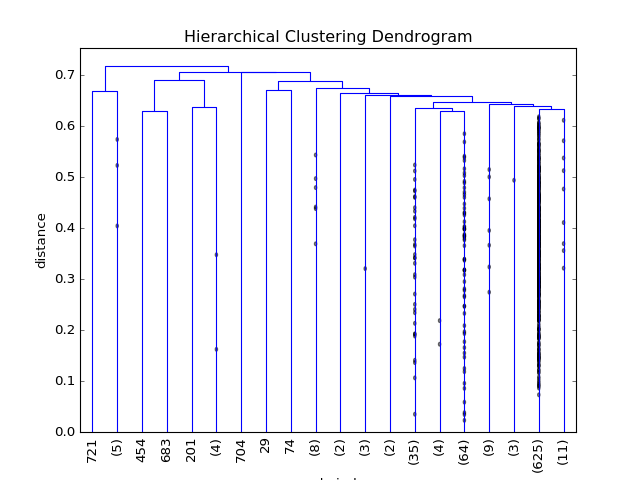

In [44]:
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    spcluster,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,
)
#plt.tight_layout()
plt.show()

In [45]:
logger.info('Computing co-occurence graph')

T=[' '.join(w) for w in sentences_nouns]

Oct-07-2016 02:17:34 Computing co-occurence graph


In [46]:
for line in T[0:10]: print line

boys
gray
honey

let
honey
flight hours
dane county airport minutes traffic
minutes butt van



In [47]:
logger.info(len(T))

Oct-07-2016 02:17:36 1450


In [48]:
##Co-occurence matrix
cv=CountVectorizer(token_pattern=u'(?u)\\b([^\\s]+)')
bow_matrix = cv.fit_transform(T)
id2word={}
for key, value in cv.vocabulary_.items():
    id2word[value]=key

ids=[]
for key,value in cv.vocabulary_.iteritems():
    if key in model_comb_vocab:
        ids.append(value)

sort_ids=sorted(ids)
bow_reduced=bow_matrix[:,sort_ids]
normalized = TfidfTransformer().fit_transform(bow_reduced)
similarity_graph_reduced=bow_reduced.T * bow_reduced

In [49]:
##Depth-rank weighting of edges, weight of edge i,j=cosine of angle between them
logger.info('Computing degree')
m,n=similarity_graph_reduced.shape

cx=similarity_graph_reduced.tocoo()
keyz=[id2word[sort_ids[w]] for w in xrange(len(sort_ids))]
data=[]
ro=[]
co=[]
for i,j,v in itertools.izip(cx.row, cx.col, cx.data):
    if v>0 and i!=j:
        value=1
        if value>0:
            ro.append(i)
            co.append(j)
            data.append(value)

SS=sp.sparse.coo_matrix((data, (ro, co)), shape=(m,n))
SP_full=SS.tocsc()
id_word={w:id2word[sort_ids[w]] for w in xrange(len(sort_ids))}
word_id={value:key for key,value in id_word.items()}

Oct-07-2016 02:17:39 Computing degree


In [50]:
logger.info('Computing metrics')
#compute metrics
degsum=SP_full.sum(axis=1)
deg={}
for x in xrange(len(sort_ids)):
    deg[id2word[sort_ids[x]]]=int(degsum[x])

max_deg=max(deg.values())
max_depth=max(depth.values())

temp_deg_mod={w:np.log(1+deg[w])/np.log(1+max_deg) for w in deg.iterkeys()}
alpha=np.log(0.5)/np.log(np.median(temp_deg_mod.values()))
deg_mod={key:value**alpha for key, value in temp_deg_mod.iteritems()}

temp={key:value*1./max_depth for key, value in depth.iteritems()}
alpha=np.log(0.5)/np.log(np.median(temp.values()))
depth_mod={key:value**alpha for key, value in temp.iteritems()}

temp={key:deg_mod[key]*depth_mod[key] for key in depth_mod.iterkeys()}
max_metric=np.max(temp.values())
metric={key:value*1./max_metric for key,value in temp.iteritems()}

Oct-07-2016 02:17:40 Computing metrics


In [51]:
for key in deg:
    if 'bird' in key: print key

birdcage
bird


In [52]:
logger.info('max_deg = %s, max_depth = %s',max_deg, max_depth)

Oct-07-2016 02:17:43 max_deg = 23, max_depth = 63


In [89]:
##Kmeans
NUM_TOPICS = 50
K=NUM_TOPICS
kmeans=KMeans(n_clusters=K)
kmeans.fit([w for w in data_d2v])
kmeans_label={word_d2v[x]:kmeans.labels_[x] for x in xrange(len(word_d2v))}

kmeans_label_ranked={}

topic=[[] for i in xrange(K)]
clust_depth=[[] for i in xrange(K)]
for i in xrange(K):
    topic[i]=[word_d2v[x] for x in xrange(len(word_d2v)) if kmeans.labels_[x]==i]
    temp_score=[metric[w] for w in topic[i]]
    clust_depth[i]=-np.mean(sorted(temp_score,reverse=True)[:])#int(np.sqrt(len(topic[i])))])
index=np.argsort(clust_depth)
for num,i in enumerate(xrange(K)):
    for w in topic[index[i]]:
        kmeans_label_ranked[w]=i

In [90]:
logger.info('Done...Generating output')
lister=[]
to_show=K
to_show_words=20 #the maximum number of words of each type to display
for i in xrange(to_show):
    top=topic[index[i]]
    sort_top=[w[0] for w in sorted([[w,metric[w]] for w in top],key=itemgetter(1),reverse=True)]
    lister.append(['Topic %d' %(i+1)]+sort_top[:to_show_words])

max_len=max([len(w) for w in lister])
new_list=[]
for list_el in lister:
    new_list.append(list_el + [''] * (max_len - len(list_el)))
Topics=list(itertools.izip_longest(*new_list))
#X.insert(len(X),[-int(clust_depth[index[w]]*100)*1./100 for w in xrange(K)])
sorted_words=[w[0] for w in sorted(metric.items(),key=itemgetter(1),reverse=True)][:to_show_words]

Oct-07-2016 03:02:28 Done...Generating output


In [91]:
score_words = sorted_words
deep_words = [w[0] for w in depth.most_common(to_show_words)]
filer = 'wiki_simple.txt'
outfile_topics = data_directory + filer.split('.')[0] + '_topics.csv'
outfile_score = data_directory + filer.split('.')[0] + '_score.csv'
outfile_depth = data_directory + filer.split('.')[0] + '_depth.csv'
b = open(outfile_topics, 'wb')
a = csv.writer(b)
a.writerows(Topics)
b = open(outfile_score, 'wb')
a = csv.writer(b)
a.writerows([[w] for w in score_words])
b = open(outfile_depth, 'wb')
a = csv.writer(b)
a.writerows([[w] for w in deep_words])

In [92]:
score_words[0:10]

[u'something',
 u'thing',
 u'everything',
 u'anything',
 u'things',
 u'kind',
 u'look',
 u'somebody',
 u'wait',
 u'fun']

In [93]:
columns = 5
print 'Total number of Topics = {}.'.format(K)
for j in range(K/columns + 1):
    first = j*columns + 1;last = (j*columns + columns)
    print 'Displaying Topics {} thru {}.'.format(first, last)
    print tabulate([Topics[i][first-1:last] for i in range(0,21)], tablefmt=u'psql')

Total number of Topics = 50.
Displaying Topics 1 thru 5.
+------------+---------------+--------------+----------+-----------+
| Topic 1    | Topic 2       | Topic 3      | Topic 4  | Topic 5   |
| something  | minutes       | asset        | life     | somebody  |
| thing      | days          | company      | living   | fun       |
| everything | day           | assets       | lives    | damn      |
| anything   | weeks         | telecom      | struggle | tomorrow  |
| things     | minute        | companies    | tragedy  | kids      |
| kind       | week          | board        | death    | yeah      |
| look       | morning       | stock        | liberty  | guys      |
| way        | weekend       | verizon      | anarchy  | hey       |
| lot        | months        | corporations | family   | thank     |
| nothing    | month         | employees    |          | mom       |
| instinct   | thanksgivings | shareholders |          | sorry     |
| breaks     | night         | brand        | 

In [94]:
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, BoxZoomTool, WheelZoomTool, ResetTool, PanTool, BoxSelectTool
from bokeh.models import ColorBar, LinearColorMapper, FixedTicker, Circle
import bokeh.palettes
from bokeh.models.widgets import Div, DataTable, TableColumn
from bokeh.layouts import gridplot, widgetbox
from bokeh.io import push_notebook
from ipywidgets import interact
from IPython.display import display, clear_output

In [95]:
output_notebook()

Loading BokehJS ...

In [96]:
#X_2D = bhtsne.tsne(np.array(data_d2v))

In [97]:
import pandas as pd

In [98]:
metrics_clean = []
for w in word_d2v:
    if w in metric:
        metrics_clean.append(metric[w])

df = pd.DataFrame(zip(word_d2v,[kmeans_label_ranked[w] for w in word_d2v],
                      metrics_clean,X_2D[:,0],X_2D[:,1]),
                  columns=['word','topic','metric','x','y'])

In [101]:
dft = df[df['topic']==0]
print len(dft)
dft

29


,word,topic,metric,x,y
162,something,0,1.000000,-4.125321,4.451399
164,sense,0,0.431163,0.555744,2.062500
204,things,0,0.857147,-3.718834,4.042814
215,looks,0,0.487998,-2.106563,6.366049
227,creations,0,0.436262,-3.279929,3.130324
238,smarter,0,0.000000,-2.374186,-1.334644
270,thing,0,0.948220,-4.386773,4.120755
325,idea,0,0.000000,4.034847,3.695733
342,lot,0,0.612429,-3.205926,5.856308
355,kind,0,0.806115,-0.510612,3.362355


In [102]:
-

In [138]:
help(bokeh.models.PanTool)

Help on class PanTool in module bokeh.models.tools:

class PanTool(Drag)
 |  *toolbar icon*: |pan_icon|
 |  
 |  The pan tool allows the user to pan a Plot by left-dragging
 |  a mouse, or on touch devices by dragging a finger or stylus, across
 |  the plot region.
 |  
 |  The pan tool also activates the border regions of a Plot for "single
 |  axis" panning. For instance, dragging in the vertical border or axis
 |  will effect a pan in the vertical direction only, with the horizontal
 |  dimension kept fixed.
 |  
 |  .. |pan_icon| image:: /_images/icons/Pan.png
 |      :height: 18pt
 |  
 |  Method resolution order:
 |      PanTool
 |      Drag
 |      Tool
 |      bokeh.model.Model
 |      bokeh.core.properties.HasProps
 |      bokeh.util.callback_manager.CallbackManager
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  get_class(cls, view_model_name) from __builtin__.type
 |      Given a __view_model__ name, returns the corresponding class
 |      object
 |  
 |  

In [ ]:
interact(update,add_colorbar=True);

In [ ]:
for p in bokeh.palettes.brewer.keys():
    print p, bokeh.palettes.brewer[p].keys()

In [104]:
from scipy.cluster.hierarchy import fcluster
max_d = 10
clusters = fcluster(spcluster, max_d, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,